**Table of contents**<a id='toc0_'></a>    
- [SemEval 2023 Task 10 Subtask A -- semi-supervised: label unlabeled data](#toc1_)    
  - [Central functions](#toc1_1_)    
  - [Training the baseline model on the training data](#toc1_2_)    
  - [Apply baseline model to additional data](#toc1_3_)    
  - [Analyze data](#toc1_4_)    
- [Generate additional trainingsdata](#toc2_)    
  - [Next step: train with newtrain](#toc2_1_)    
  - [Tokenize](#toc2_2_)    
- [Reste](#toc3_)    
  - [create training set](#toc3_1_)    
  - [Ideas for improvement](#toc3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


In this notebook we test which language model (distilbert, RoBERTa...) performs best when finetuned on the gold training data. Then we train the finetuned model on the Reddit and Gab data to generate additional training data. Those classified entries with the highest confidence score for class assigment are used for further training of our model.

In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 22.0 MB/s eta 0:00:0

# <a id='toc1_'></a>[SemEval 2023 Task 10 Subtask A -- semi-supervised: label unlabeled data](#toc0_)

## <a id='toc1_1_'></a>[Central functions](#toc0_)

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_from_disk
from datasets import load_dataset
from datasets import DatasetDict
from datasets import Dataset
import torch
import sys
import urllib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_metrics(pred):
  """ Computes accuracy, f1 score, precision and recall on given data.

      Args:
        pred ():
      
      Returns:
        Dataframe containing different performance metrics.
  """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}


def tokenize_and_train(dataset, checkpoint, model_name, eval, num_epochs):
    """ Tokenizes and trains the model.
  
   Args:
    dataset (DatasetDict):
    checkpoint (str): Name of the pretrained model (on Huggingface), e.g. "bert-base-uncased".
    model_name (str): Name of the model to be saved.
    eval (bool): If true, the model is evaluated on the test set.
    num_epochs (int): Number of epochs the model is trained on.

  Returns:
    model (): Trained model.
  """  

    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    def tokenize(batch):
        tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        return tokenizer(batch["text"], padding=True, truncation=True)
    tokenized_dataset = dataset.map(tokenize, batched=True, batch_size=1000)
    model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=2)
         .to(device))
    batch_size = 64
    training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=num_epochs,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="steps",
                                  disable_tqdm=False,
                                  push_to_hub=hugging, # HuggingFace account necessary
                                  log_level="error")
    if eval == True:
        trainer = Trainer(model=model, args=training_args,
                      compute_metrics=compute_metrics,
                      train_dataset=tokenized_dataset["train"],
                      eval_dataset=tokenized_dataset["test"],
                      tokenizer=tokenizer)
    else:
        trainer = Trainer(model=model, args=training_args,
                      train_dataset=tokenized_dataset,
                      tokenizer=tokenizer)
    trainer.train()
    trainer.save_model(model_name)
    return trainer
    

def tokenize_and_predict(dataset, checkpoint):
    myclassifier = pipeline("text-classification",checkpoint,use_auth_token=True) 
    def myclass(batch):
      return {"score": myclassifier(batch["text"], padding=True, truncation=True, function_to_apply="softmax",return_all_scores=True)}#top_k=None 
    predictions = dataset.map(myclass, batched=True)
    return predictions
    


def tokenize_and_predict_no_pipe(dataset, checkpoint):
    """ Tokenizes the data and makes predictions.

      Args:
        dataset (DatasetDict):
        checkpoint (str): Name of a pretrained model, e.g. "bert-base-uncased"

      Returns:
        Predictions in a tuple of (logits, labels) where logits are a tensor of shape (batch_size, num_labels) and labels are a tensor of shape (batch_size).
    
    
    """
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    def tokenize(batch):
        tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        return tokenizer(batch["text"], padding=True, truncation=True)
    tokenized_dataset = dataset.map(tokenize, batched=True, batch_size=1000)
    model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=2)
         .to(device))
    batch_size = 64
    trainer = Trainer(model=model, #args=training_args,
                    train_dataset=tokenized_dataset,
                    tokenizer=tokenizer)
    predictions = trainer.predict(tokenized_dataset)
    return predictions



def train_and_predict(dataset, checkpoint, model_name, num_epochs):
    """
    Trains a model on the dataset and returns the predictions.

    Args:
      dataset (DatasetDict) : 
      checkpoint (str): Name of a pretrained model, e.g. "bert-base-uncased".
      model_name (str): Name of the model to be saved.
      num_epochs (int): Number of epochs the model is trained on.

    Returns: 
      Returns the predictions in a tuple of (logits, labels).
    """

    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    def tokenize(batch):
        tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        return tokenizer(batch["text"], padding=True, truncation=True)
    tokenized_dataset = dataset.map(tokenize, batched=True, batch_size=1000)
    model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=2, ignore_mismatched_sizes=True)
         .to(device))
    batch_size = 64
    training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=num_epochs,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  eval_steps = 50,
                                  evaluation_strategy="steps",
                                  disable_tqdm=False)
    trainer = Trainer(model=model, args=training_args,
                      compute_metrics=compute_metrics,
                      train_dataset=tokenized_dataset["train"],
                      eval_dataset=tokenized_dataset["test"],
                      tokenizer=tokenizer)
    trainer.train()
    predictions = trainer.predict(tokenized_dataset["test"])
    return predictions


def int2str(num):
  """ Turn integer labels to string labels.

  Parameters:
    num (int): Label as an integer.

  Returns: 
    Labels in string form.
  """
  if num == 0:
    return "not sexist"
  elif num == 1:
    return "sexist"

# Load the data

In [ ]:
train_data = load_dataset("csv", 
                  data_files="https://raw.githubusercontent.com/WiebkePetersen/hhuEDOS2023/main/dataset/train/train_all_tasks.csv") 

dev_data = load_dataset("csv",
                  data_files="https://raw.githubusercontent.com/WiebkePetersen/hhuEDOS2023/main/dataset/dev/dev_task_a_entries.csv")

test_data = load_dataset("csv", 
                  data_files="https://raw.githubusercontent.com/WiebkePetersen/hhuEDOS2023/main/dataset/test/test_task_a_entries.csv")

gab_data = load_dataset("csv", 
                  data_files="https://raw.githubusercontent.com/WiebkePetersen/hhuEDOS2023/main/dataset/train/gab_1M_unlabelled.csv")

reddit_data = load_dataset("csv", 
                  data_files="https://raw.githubusercontent.com/WiebkePetersen/hhuEDOS2023/main/dataset/train/reddit_1M_unlabelled.csv")



In [ ]:
train_data

## <a id='toc1_2_'></a>[Train the baseline model on the training data](#toc0_)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data = train_data.rename_column("label_sexist", "label")
train_data = train_data.class_encode_column("label")
datadict = train_data["train"].train_test_split(shuffle=True, test_size=0.1, seed=42) # 


# train model on sexist data in train set of datadict 
checkpoint = "distilbert-base-uncased"
model_name = checkpoint + "sexist_baseline"
trainer = tokenize_and_train(datadict, checkpoint, model_name, True, 2)
predictions = tokenize_and_predict(datadict["test"], model_name)



Using custom data configuration default-a7e950c2891a3be3
Reusing dataset csv (C:\Users\Wiebke Petersen\.cache\huggingface\datasets\csv\default-a7e950c2891a3be3\0.0.0\6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Wiebke Petersen\.cache\huggingface\datasets\csv\default-a7e950c2891a3be3\0.0.0\6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e\cache-e0b2f74beffbfb23.arrow
Loading cached processed dataset at C:\Users\Wiebke Petersen\.cache\huggingface\datasets\csv\default-a7e950c2891a3be3\0.0.0\6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e\cache-b55750e1146a88f5.arrow
Loading cached split indices for dataset at C:\Users\Wiebke Petersen\.cache\huggingface\datasets\csv\default-a7e950c2891a3be3\0.0.0\6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e\cache-dad98509f8d9d199.arrow and C:\Users\Wiebke Petersen\.cache\huggingface\datasets\csv\default-a7e950c2891a3be3\0.0.0\6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e\cache-3ffeeefe94a62cac.arrow
Pushing split train to the Hub.
The repository already exists: the `private` keyword argument will be ignored.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split test to the Hub.
The repository already exists: the `private` keyword argument will be ignored.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

,rewire_id,text,label,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",0,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",0,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,0,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,0,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,0,none,none


In [ ]:
# load data from HuggingFace
data_name = "Wiebke/SemEvalTask10_train_all_tasks"
datadict = load_dataset(data_name)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/1400 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/12600 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Wiebke___parquet/default-9cd9a3e0e3e5d94c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Verteilung der Label ist in Test und Train ausreichend ähnlich
list = datadict['test']["label"][:]
print(sum(list)/len(list))

list = datadict['train']["label"][:]
print(sum(list)/len(list))


0.2592857142857143
0.24087301587301588


In [ ]:
# get predicted labels from scores
def predicted_label(batch):
  """  xyz.

    Parameters:
      batch (xyz): 

    Returns:
  """
  s0 = batch['score'][0]['score']
  s1 = batch['score'][1]['score']
  return {"predicted_label": np.argmax((s0,s1))}

predictions = predictions.map(predicted_label)

# Create a dataframe with test data and their scores for label 'not sexist'
probs_class0 = [p[0]["score"] for p in predictions["score"]]
datadict.set_format(type="pandas")
df_test = datadict["test"][:]
df_test["probs_class0"] = probs_class0
df_test["predicted_label"] = predictions["predicted_label"]
datadict.reset_format() # reset output format
df_test.head()

Erstelle ein Dataframe für die Testdaten mit den Scores für Klasse 0.

In [ ]:
# get accuracy
df_test[df_test['predicted_label']== df_test['label']].shape[0]/df_test.shape[0]

In [ ]:
df_test.to_csv("df_test.csv")

### Try different models on training data

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
# train model on sexist data in train set of datadict and save model to hub
def train_predict_acc(datadict, checkpoint,num_epochs):
      """
    Trains model on train set of given data.

    Parameters:
      datadict (Datadict): Data in form of the Datadict Class from huggingface.
      checkpoint (str): Name of a pretrained model, e.g. "bert-base-uncased".
      num_epochs (int): Number of epochs the model is trained on.

    Returns: A tuple with the name of the current tested model and the corresponding performance scores. 

  """
    model_name = "Wiebke/"+ checkpoint+ "sexist_baseline"
    predictions = train_and_predict(datadict, checkpoint, model_name, num_epochs)
    predicted_label=np.argmax(predictions.predictions,axis=1)
    true_label = datadict["test"]["label"]
    acc = accuracy_score(true_label,predicted_label)
    f1 = f1_score(true_label,predicted_label,average="weighted")
    print(checkpoint)
    print("accuracy:", acc)
    print("fscore:", f1)
    return (checkpoint,  acc, f1, predicted_label,true_label)


In [ ]:
comparison = []

epoch = 2
check,acc, f1, pred, true = train_predict_acc(datadict,"distilbert-base-uncased",epoch)
comparison += [(check,acc,f1,epoch)]


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.516589,0.742143,0.635049
100,No log,0.402073,0.838571,0.826499
150,No log,0.364918,0.836429,0.837351
200,No log,0.338847,0.855000,0.848431
250,No log,0.335227,0.854286,0.852918
300,No log,0.325094,0.858571,0.855322
350,No log,0.324598,0.864286,0.858403


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: te

distilbert-base-uncased
accuracy: 0.8535714285714285
fscore: 0.851684287444798


In [ ]:
gc.collect()
torch.cuda.empty_cache()
check,acc, f1, pred, true = train_predict_acc(datadict,"bert-base-uncased",epoch)
comparison += [(check,acc,f1,epoch)]


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file to

  0%|          | 0/13 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file to

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.493582,0.743571,0.637071
100,No log,0.400375,0.832857,0.812983
150,No log,0.359377,0.845714,0.844862
200,No log,0.335098,0.865714,0.859365
250,No log,0.338557,0.852857,0.854810
300,No log,0.320355,0.870000,0.867013
350,No log,0.319289,0.876429,0.872526


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category,

bert-base-uncased
accuracy: 0.865
fscore: 0.8639303037600193


In [ ]:
gc.collect()
torch.cuda.empty_cache()
#check,acc, f1, pred, true = train_predict_acc(datadict,"bert-large-uncased",2)
#comparison += [(check,acc,f1)]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/80792f8e8216b29f3c846b653a0ff0a37c210431/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/80792f8e8216b29f3c846b653a0ff0a37c210431/vocab.txt
loading fil

  0%|          | 0/3 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/80792f8e8216b29f3c846b653a0ff0a37c210431/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/80792f8e8216b29f3c846b653a0ff0a37c210431/vocab.txt
loading fil

  0%|          | 0/26 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/80792f8e8216b29f3c846b653a0ff0a37c210431/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-large-uncased/snapshots/80792f8e8216b29f3c846b653a0ff0a37c210431/vocab.txt
loading fil

OutOfMemoryError: ignored

In [ ]:
gc.collect()
torch.cuda.empty_cache()
check,acc, f1, pred, true = train_predict_acc(datadict,"bert-base-cased",epoch)
comparison += [(check,acc,f1,epoch)]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu"

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/vocab.txt
loading file tokenize

  0%|          | 0/13 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/vocab.txt
loading file tokenize

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/pytorch_model.bin
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Ber

Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.498322,0.740714,0.630382
100,No log,0.358797,0.845714,0.837157
150,No log,0.348488,0.842857,0.843810
200,No log,0.320232,0.866429,0.863726
250,No log,0.325338,0.857857,0.859243
300,No log,0.306107,0.873571,0.869428
350,No log,0.305010,0.875000,0.870602


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category,

bert-base-cased
accuracy: 0.8707142857142857
fscore: 0.869689867622029


In [ ]:
gc.collect()
torch.cuda.empty_cache()
epoch = 3
check,acc, f1, pred, true = train_predict_acc(datadict,"bert-base-cased",epoch)
comparison += [(check,acc,f1,epoch)]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/vocab.txt
loading file tokenize

Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.494791,0.740714,0.630382
100,No log,0.354221,0.847857,0.839312
150,No log,0.345087,0.845000,0.845611
200,No log,0.323276,0.862143,0.860916
250,No log,0.319481,0.861429,0.861795
300,No log,0.307849,0.871429,0.866185
350,No log,0.307799,0.877143,0.869448
400,No log,0.297209,0.875000,0.871053
450,No log,0.312205,0.872857,0.870215
500,0.320100,0.319954,0.870714,0.868648


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category,

bert-base-cased
accuracy: 0.8685714285714285
fscore: 0.8683338557629575


In [ ]:
gc.collect()
torch.cuda.empty_cache()
epoch = 2
check,acc, f1, pred, true = train_predict_acc(datadict,"distilbert-base-uncased-finetuned-sst-2-english",epoch)
comparison += [(check,acc,f1,epoch)]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased-finetuned-sst-2-english/snapshots/bfdd146ea2b6807255b73527f1327ca12b6ed5c4/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased-finetuned-sst-2-english/snapshots/bfdd146ea2b6807255b73527f1327ca12b6ed5c4/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased-finetuned-sst-2-english/snapshots/bfdd146ea2b6807255b73527f1327ca12b6ed5c4/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased-finetuned-sst-2-english/snapshots/bfdd146ea2b6807255b73527f1327ca12b6ed5c4/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased-finetuned-sst-2-english/snapshots/bfdd146ea2b6807255b73527f1327ca12b6ed5c4/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache

  0%|          | 0/13 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased-finetuned-sst-2-english/snapshots/bfdd146ea2b6807255b73527f1327ca12b6ed5c4/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased-finetuned-sst-2-english/snapshots/bfdd146ea2b6807255b73527f1327ca12b6ed5c4/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argum

Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.520595,0.740000,0.637760
100,No log,0.431409,0.807143,0.787846
150,No log,0.384751,0.827857,0.827309
200,No log,0.358355,0.851429,0.844404
250,No log,0.363032,0.837143,0.836396
300,No log,0.347083,0.857857,0.850270
350,No log,0.344445,0.857857,0.850659


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: te

distilbert-base-uncased-finetuned-sst-2-english
accuracy: 0.85
fscore: 0.845876409774436


In [ ]:
gc.collect()
torch.cuda.empty_cache()
check,acc, f1, pred, true = train_predict_acc(datadict,"cardiffnlp/twitter-roberta-base-sentiment",epoch)
comparison += [(check,acc,f1,epoch)]

Could not locate the tokenizer configuration file, will try to use the model config instead.


Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tra

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/special_tokens_map.json
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentim

  0%|          | 0/2 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  

  0%|          | 0/13 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/pytorch_model.bin
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to no

Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.434884,0.797143,0.792482
100,No log,0.333795,0.850714,0.843155
150,No log,0.345889,0.846429,0.848985
200,No log,0.301996,0.863571,0.860361
250,No log,0.328875,0.850000,0.852660
300,No log,0.303889,0.873571,0.870597
350,No log,0.307391,0.872857,0.870076


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, rewire_id, 

cardiffnlp/twitter-roberta-base-sentiment
accuracy: 0.8571428571428571
fscore: 0.8584778940816092


In [ ]:
gc.collect()
torch.cuda.empty_cache()
check,acc, f1, pred, true = train_predict_acc(datadict,"roberta-base",epoch)
comparison += [(check,acc,f1,epoch)]

Could not locate the tokenizer configuration file, will try to use the model config instead.


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_toke

  0%|          | 0/2 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at /root/.cache/huggingface/hub/mo

  0%|          | 0/13 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at /root/.cache/huggingface/hub/mo

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/pytorch_model.bin
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some 

Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.458880,0.770000,0.751326
100,No log,0.348020,0.848571,0.839308
150,No log,0.316844,0.867143,0.865764
200,No log,0.320959,0.854286,0.853480
250,No log,0.326581,0.856429,0.858498
300,No log,0.301722,0.868571,0.865841
350,No log,0.296500,0.877857,0.874287


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, rewire_id, 

roberta-base
accuracy: 0.8678571428571429
fscore: 0.8684909880346897


In [ ]:
# FEhler:
# ---> 20     preds = pred.predictions.argmax(-1)
#     21     f1 = f1_score(labels, preds, average="weighted")
#     22     acc = accuracy_score(labels, preds)
#AttributeError: 'tuple' object has no attribute 'argmax'
gc.collect()
torch.cuda.empty_cache()
#check,acc, f1, pred, true = train_predict_acc(datadict,"hf-internal-testing/tiny-random-BartForSequenceClassification",epoch)
#comparison += [(check,acc,f1,epoch)]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/31.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-rand

  0%|          | 0/2 [00:00<?, ?ba/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-rand

  0%|          | 0/13 [00:00<?, ?ba/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-rand

Downloading:   0%|          | 0.00/986 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/config.json
Model config BartConfig {
  "_name_or_path": "hf-internal-testing/tiny-random-BartForSequenceClassification",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "BartForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 16,
  "decoder_attention_heads": 4,
  "decoder_ffn_dim": 4,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 2,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 4,
  "encoder_ffn_dim": 4,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 2,
  "eos_token_id": 2,
  "forced_eos_token_id": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0":

Downloading:   0%|          | 0.00/140k [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--hf-internal-testing--tiny-random-BartForSequenceClassification/snapshots/5ceca1f5dbcf32c04ef44355e4bc66128cd4ea8b/pytorch_model.bin
All model checkpoint weights were used when initializing BartForSequenceClassification.

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at hf-internal-testing/tiny-random-BartForSequenceClassification and are newly initialized because the shapes did not match:
- classification_head.out_proj.weight: found shape torch.Size([3, 16]) in the checkpoint and torch.Size([2, 16]) in the model instantiated
- classification_head.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
PyTorch: setting up devices
The default value for the training argument `--report_to` will c

Step,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `BartForSequenceClassification.forward` and have been ignored: text, rewire_id, label_category, label_vector. If text, rewire_id, label_category, label_vector are not expected by `BartForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 64


AttributeError: ignored

In [ ]:
# too large
# OutOfMemoryError: CUDA out of memory. Tried to allocate 172.00 MiB (GPU 0; 14.76 GiB total capacity; 13.53 GiB already allocated; 93.75 MiB free; 13.88 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
gc.collect()
torch.cuda.empty_cache()
#check,acc, f1, pred, true = train_predict_acc(datadict,"facebook/bart-large-mnli",epoch)
#comparison += [(check,acc,f1,epoch)]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-mnli/snapshots/9fc9c4e1808b5613968646fa771fc43fb03995f2/config.json
Model config BartConfig {
  "_name_or_path": "facebook/bart-large-mnli",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForSequenceClassification"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "contradiction",
    "1": "neutral",
    "2": "entailment"
  },
  

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-mnli/snapshots/9fc9c4e1808b5613968646fa771fc43fb03995f2/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-mnli/snapshots/9fc9c4e1808b5613968646fa771fc43fb03995f2/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-mnli/snapshots/9fc9c4e1808b5613968646fa771fc43fb03995f2/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-mnli/snapshots/9fc9c4e1808b5613968646fa771fc43fb03995f2/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-mnli/snapshots/9fc9c4e1808b5613968646fa771fc43fb03995f2/config.json
Model config BartConfig {
  "_nam

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-mnli/snapshots/9fc9c4e1808b5613968646fa771fc43fb03995f2/config.json
Model config BartConfig {
  "_name_or_path": "facebook/bart-large-mnli",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForSequenceClassification"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "contradiction",
    "1": "neutral",
    "2": "entailment"
  },
  

  0%|          | 0/13 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-mnli/snapshots/9fc9c4e1808b5613968646fa771fc43fb03995f2/config.json
Model config BartConfig {
  "_name_or_path": "facebook/bart-large-mnli",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForSequenceClassification"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "contradiction",
    "1": "neutral",
    "2": "entailment"
  },
  

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-mnli/snapshots/9fc9c4e1808b5613968646fa771fc43fb03995f2/pytorch_model.bin
All model checkpoint weights were used when initializing BartForSequenceClassification.

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large-mnli and are newly initialized because the shapes did not match:
- classification_head.out_proj.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classification_head.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will

OutOfMemoryError: ignored

In [ ]:
# too large
# OutOfMemoryError: CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.76 GiB total capacity; 13.53 GiB already allocated; 93.75 MiB free; 13.88 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
gc.collect()
torch.cuda.empty_cache()
#check,acc, f1, pred, true = train_predict_acc(datadict,"facebook/bart-base",epoch)
#comparison += [(check,acc,f1,epoch)]

Could not locate the tokenizer configuration file, will try to use the model config instead.


Downloading:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/config.json
Model config BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2":

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/config.json
Model config BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false

  0%|          | 0/2 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/config.json
Model config BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gra

  0%|          | 0/13 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/config.json
Model config BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gra

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/pytorch_model.bin
All model checkpoint weights were used when initializing BartForSequenceClassification.

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.out_proj.weight', 'classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: ignored

In [ ]:
gc.collect()
torch.cuda.empty_cache()


In [ ]:
comparison

[('distilbert-base-uncased', 0.8535714285714285, 0.851684287444798, 2),
 ('bert-base-uncased', 0.865, 0.8639303037600193, 2),
 ('bert-base-cased', 0.8707142857142857, 0.869689867622029, 2),
 ('bert-base-cased', 0.8685714285714285, 0.8683338557629575, 3),
 ('distilbert-base-uncased-finetuned-sst-2-english',
  0.85,
  0.845876409774436,
  2),
 ('cardiffnlp/twitter-roberta-base-sentiment',
  0.8571428571428571,
  0.8584778940816092,
  2),
 ('roberta-base', 0.8678571428571429, 0.8684909880346897, 2)]

In [ ]:
# pd dataframe from dictiona
dfcomp = pd.DataFrame.from_dict(comparison)

In [ ]:
dfcomp

# -> bert-base-cased shows the best results

,0,1,2,3
0,distilbert-base-uncased,0.853571,0.851684,2
1,bert-base-uncased,0.865000,0.863930,2
2,bert-base-cased,0.870714,0.869690,2
3,bert-base-cased,0.868571,0.868334,3
4,distilbert-base-uncased-finetuned-sst-2-english,0.850000,0.845876,2
5,cardiffnlp/twitter-roberta-base-sentiment,0.857143,0.858478,2
6,roberta-base,0.867857,0.868491,2


# Apply baseline model to additional unlabeled data

## Reddit data

In [ ]:
# process all reddit data at once
checkpoint = "bert-base-casedepoch3" # == model_baseline_sexist

reddit_predictions = tokenize_and_predict_no_pipe(reddit_data["train"], model_baseline_sexist) 
np.save("reddit_all_predictions_"+ checkpoint,reddit_predictions.predictions)
all_predictions_reddit= np.load("reddit_all_predictions_" + checkpoint + ".npy")



In [ ]:
from scipy.special import softmax
pred_list = softmax(all_predictions, axis=1)
pred_list = pred_list[:,0].tolist()

reddit_data.set_format(type="pandas")
reddit_all = reddit_data["train"][:]
reddit_data.reset_format()
reddit_all["probs_class0"] = pred_list
reddit_all.head()

In [ ]:
reddit_all.to_csv("drive/MyDrive/data/Semeval23Task10/reddit_all_with_predictions" + checkpoint + ".csv")


## Gab data

In [ ]:
gab_predictions = tokenize_and_predict_no_pipe(gab_data["train"], model_baseline_sexist)

np.save("gab_all_predictions_"+ checkpoint,gab_predictions.predictions)
all_predictions_gab = np.load("gab_all_predictions_" + checkpoint + ".npy")

# save dataframe with gab data and the corresponding predictions
pred_list = softmax(all_predictions_gab, axis=1)
pred_list = pred_list[:,0].tolist()

gab_data.set_format(type="pandas")
gab_all = gab_data["train"][:]
gab_data.reset_format()
gab_all["probs_class0"] = pred_list
gab_all.head()

gab_all.to_csv('gab_all_predictions' + checkpoint)

## <a id='toc1_4_'></a>[Analyze data](#toc0_)

In [ ]:
df_test = pd.read_csv("df_test.csv")


def eval(row):
  """ Adds column to the dataframe indicating false and correct predictions based on the corresponding class probabilities.

  Args:
    row (pd.Dataframe): Dataframe with class predictions.

  """
  if row['label'] == 0:
      if row['probs_class0'] > 0.5:
          return 'correct'
      else:
          return 'pred1_wrong'
        
  elif row['label'] == 1:
      if row['probs_class0'] < 0.5:
          return 'correct'
      else:
          return 'pred0_wrong' 

df_test['eval'] = df_test.apply(eval, axis=1)
df_test.head()

,Unnamed: 0,rewire_id,text,label,label_category,label_vector,probs_class0,predicted_label
0,0,sexism2022_english-1422,"Stupid white woman, liberal mind set is screwe...",1,2. derogation,2.2 aggressive and emotive attacks,0.695571,0
1,1,sexism2022_english-12593,"""Baby's in the cradle, Brother's on the town. ...",0,none,none,0.892695,0
2,2,sexism2022_english-17802,#VoteDemOut seditionist wanna be socialists ne...,0,none,none,0.983848,0
3,3,sexism2022_english-13656,"Naked outdoors topic, star to fav ))) [URL]",0,none,none,0.986400,0
4,4,sexism2022_english-9777,I will probably try to date both of the girls ...,0,none,none,0.769895,0


In [ ]:
def eval(row):
    if row['label'] == 0:
        if row['probs_class0'] > 0.5:
            return 'correct'
        else:
            return 'pred1_wrong'
        
    elif row['label'] == 1:
        if row['probs_class0'] < 0.5:
            return 'correct'
        else:
            return 'pred0_wrong' 

df_test['eval'] = df_test.apply(eval, axis=1)        

In [ ]:
df_test.head()

,Unnamed: 0,rewire_id,text,label,label_category,label_vector,probs_class0,predicted_label,eval
0,0,sexism2022_english-1422,"Stupid white woman, liberal mind set is screwe...",1,2. derogation,2.2 aggressive and emotive attacks,0.695571,0,pred0_wrong
1,1,sexism2022_english-12593,"""Baby's in the cradle, Brother's on the town. ...",0,none,none,0.892695,0,correct
2,2,sexism2022_english-17802,#VoteDemOut seditionist wanna be socialists ne...,0,none,none,0.983848,0,correct
3,3,sexism2022_english-13656,"Naked outdoors topic, star to fav ))) [URL]",0,none,none,0.986400,0,correct
4,4,sexism2022_english-9777,I will probably try to date both of the girls ...,0,none,none,0.769895,0,correct


<AxesSubplot:>

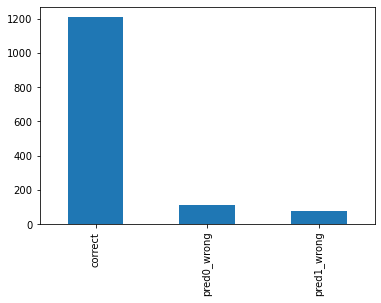

In [ ]:
import matplotlib.pyplot as plt

df_test['eval'].value_counts().plot(kind='bar')

array([[<AxesSubplot:title={'center':'correct'}>,
        <AxesSubplot:title={'center':'pred0_wrong'}>],
       [<AxesSubplot:title={'center':'pred1_wrong'}>, <AxesSubplot:>]],
      dtype=object)

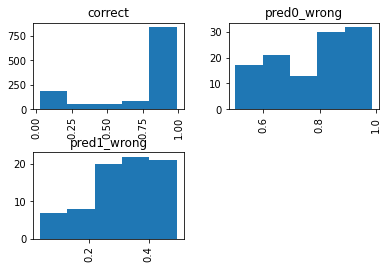

In [ ]:
# plot the distribution of the probabilities for the correct and wrong predictions
df_test['probs_class0'].hist(by=df_test['eval'], bins=5)   


Viele mit hoher Wahrscheinlichkeit fälschlich als nicht-sexistisch predicted. Wenige mit hoher Sicherheit fälschlich als sexistisch predicted.

correct        648
pred0_wrong     14
pred1_wrong      4
Name: eval, dtype: int64
number of original data: 1400


<AxesSubplot:>

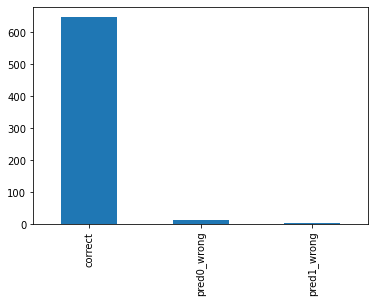

In [ ]:
# Bar plot of the number of correct and wrong predictions for the extreme cases (probs_class0 < 0.05 or >0.95)  
val = df_test['eval'].loc[(df_test['probs_class0'] < 0.05) | (df_test['probs_class0'] > 0.95)].value_counts()
print(val)
print("number of original data:", df_test.shape[0])
val.plot(kind='bar')



Mit Sicherheitsgrenzen <0.05 und >0.95 sind die Ergebnisse recht zuverlässig (Besser noch 0.025 und 0.975). Mit diesen Grenzen werden jetzt neue Trainingsdaten generiert. 

## Generate additional training data

In [ ]:
# load training data
data_name = "Wiebke/SemEvalTask10_train_all_tasks"
datadict = load_dataset(data_name)
# load data reddit_with_predictions.csv
df_reddit = pd.read_csv("data/reddit_all_with_predictionsbert-base-casedepoch3.csv")
df_gab = pd.read_csv("data/gab_all_with_predictionsbert-base-casedepoch3.csv")

df_gab.head()

Using custom data configuration default-d2bcc6390c88645c
Reusing dataset parquet (C:\Users\Wiebke Petersen\.cache\huggingface\datasets\parquet\default-d2bcc6390c88645c\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/2 [00:00<?, ?it/s]

,Unnamed: 0,text,probs_class0
0,0,JUST SAYING.... YOU LOSE BIATCHES,0.994446
1,1,HOW WOULD I DESCRIBE BERKELEY RIOTS? 1) Charmi...,0.921241
2,2,Or maybe a little south of Herring Run. More l...,0.979146
3,3,That's funny...but,0.994135
4,4,Unbelievable! It Was (((Rosenstein))) Who Hid ...,0.997081


<AxesSubplot:>

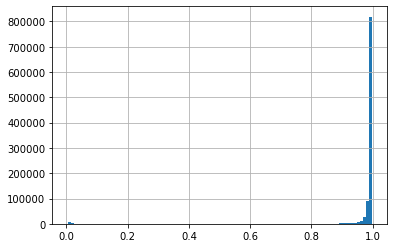

In [ ]:

df_gab['probs_class0'].hist(bins=100)

In [ ]:
# add column 'labels' to df_reddit with 1 if probs_class0<0.05 and 1 if probs_class0>0.985 and -1 otherwise
def add_labels(row):    
    if row['probs_class0'] > 0.985:
        return 0
    elif row['probs_class0'] < 0.05:
        return 1
    else:
        return -1

df_reddit['label'] = df_reddit.apply(add_labels, axis=1)
df_gab['label'] = df_gab.apply(add_labels, axis=1)
df_gab.head()



,Unnamed: 0,text,probs_class0,label
0,0,JUST SAYING.... YOU LOSE BIATCHES,0.994446,0
1,1,HOW WOULD I DESCRIBE BERKELEY RIOTS? 1) Charmi...,0.921241,-1
2,2,Or maybe a little south of Herring Run. More l...,0.979146,-1
3,3,That's funny...but,0.994135,0
4,4,Unbelievable! It Was (((Rosenstein))) Who Hid ...,0.997081,0


In [ ]:
# count number of labels
print("reddit:")
print(df_reddit['label'].value_counts())
print("gab:")
print(df_gab['label'].value_counts())

reddit:
 0    667351
-1    296846
 1     35803
Name: label, dtype: int64
gab:
 0    864068
-1    125625
 1     10307
Name: label, dtype: int64


In [ ]:
datadict['train'].set_format(type="pandas")
org0,org1 = datadict['train']["label"].value_counts()
print(org0,org1, org0/org1)


9565 3035 3.1515650741350907


In [ ]:
datadict.set_format(type="pandas")
ratio = org0/org1

reddit_count0, reddit_count_none, reddit_count1 = df_reddit['label'].value_counts()
reddit1 = df_reddit.loc[df_reddit['label'] == 1]
reddit0 = df_reddit.loc[df_reddit['label'] == 0]
#reddit0 = reddit0.sample(n=int(reddit_count1*ratio), random_state=42) # for original distribution of labels
reddit0 = reddit0.sample(n=int(reddit_count1), random_state=42) # for equal distribution of labels

gab_count0, gab_count_none, gab_count1 = df_gab['label'].value_counts()
gab1 = df_gab.loc[df_gab['label'] == 1]
gab0 = df_gab.loc[df_gab['label'] == 0]
#gab0 = gab0.sample(n=int(gab_count1*ratio), random_state=42) # for original distribution of labels
gab0 = gab0.sample(n=int(gab_count1), random_state=42) # for equal distribution of labels


# reuse old training data
newtrain = pd.concat([reddit1, reddit0, gab1, gab0, datadict['train'][:]]) 
#shuffle newtrain
newtrain = newtrain.sample(frac=1, random_state=42)
# newtrain keep only the columns 'text' and 'labels'
newtrain = newtrain[['text', 'label']]
newtrain = newtrain.reset_index(drop=True)
testdata = datadict["test"][:]
testdata = testdata[['text', 'label']]
testdata = testdata.reset_index(drop=True)
datadict.reset_format() # reset output format
new0, new1 = newtrain['label'].value_counts()
print(new0,new1, new0/new1)
print(newtrain.shape)
newtrain.head()



55675 49145 1.1328721131346018
(104820, 2)


,text,label
0,you tell this idiot bitch off,1
1,but im not. women are the arbiters of this and...,1
2,OK which one of you is taking over the Onion a...,0
3,Do we attach parachutes? In boxes?,0
4,The game's rigged dude. If you don't want whit...,0


In [ ]:
print(testdata.shape)
testdata.head()

(1400, 2)


,text,label
0,"Stupid white woman, liberal mind set is screwe...",1
1,"""Baby's in the cradle, Brother's on the town. ...",0
2,#VoteDemOut seditionist wanna be socialists ne...,0
3,"Naked outdoors topic, star to fav ))) [URL]",0
4,I will probably try to date both of the girls ...,0


In [ ]:
# make dataset from pandas dataframe no index   
newtrain_ds = Dataset.from_pandas(newtrain)
testdata = Dataset.from_pandas(testdata)
# make new datasetdict with newtrain_ds and mydata["test"]
newtrain_datadict = DatasetDict({"train": newtrain_ds, "test": testdata})
# save datadict to hub
newtrain_datadict
newtrain_datadict.push_to_hub("newtrain_reddit_gab_bert-base-casedepoch3_equal")


Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split test to the Hub.
The repository already exists: the `private` keyword argument will be ignored.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

## <a id='toc2_1_'></a>[Next step: train with newtrain](#toc0_)


In [ ]:
checkpoint = "Wiebke/bert-base-casedepoch3_sexist_baseline"
#model_name = checkpoint+ "_with_reddit_and_gab"
model_name = checkpoint+ "_with_reddit_and_gab_equal"
#newtrain_datadict = load_dataset("Wiebke/newtrain_reddit_gab_bert-base-casedepoch3", use_auth_token=True) # original distribution of labels
newtrain_datadict = load_dataset("Wiebke/newtrain_reddit_gab_bert-base-casedepoch3_equal", use_auth_token=True) # equally distributed labels
newtrain_datadict


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/1400 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/104820 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Wiebke___parquet/Wiebke--newtrain_reddit_gab_bert-base-casedepoch3_equal-26100a254d3b2683/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1400
    })
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 104820
    })
})

In [ ]:
trainer = tokenize_and_train(newtrain_datadict, checkpoint, model_name, True, 1)


## Apply to dev data

In [ ]:
model_name = checkpoint+ "_with_reddit_and_gab_equal"

data_name = "Wiebke/SemEvalTask10_train_all_tasks"
datadict = load_dataset(data_name)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Train with hold out test set from train set
trainer = tokenize_and_train(datadict["test"], model_name, model_name+"fordev", False, 1)

In [ ]:
dev_data

DatasetDict({
    train: Dataset({
        features: ['rewire_id', 'text'],
        num_rows: 2000
    })
})

In [ ]:
dev_pred = tokenize_and_predict_no_pipe(dev_data["train"], model_name+"fordev")

  0%|          | 0/2 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, rewire_id. If text, rewire_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 8
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
dev_pred.predictions

array([[ 1.09544  , -1.1923972],
       [ 3.8625257, -3.8562799],
       [ 1.8323668, -1.7864546],
       ...,
       [ 3.4317112, -3.3354402],
       [-3.8784125,  3.4195776],
       [-3.1178653,  2.6872962]], dtype=float32)

In [ ]:
y_preds = np.argmax(dev_pred.predictions, axis=1)
dev_data.set_format(type="pandas")
df = dev_data["train"][:]
df["y_preds"] = y_preds
df.head()

,rewire_id,text,y_preds
0,sexism2022_english-11999,I do not try to hard. I do what guys who get w...,0
1,sexism2022_english-9895,That sucks. We elected a Navy Seal in Missouri...,0
2,sexism2022_english-11623,Walk away and never look back. If she reaches ...,0
3,sexism2022_english-19035,basically I placed more value on her than I sh...,0
4,sexism2022_english-895,"NYT and Asian ""part ways."" But why on earth wa...",0


In [ ]:
sum(y_preds),len(y_preds)

(425, 2000)

In [ ]:
def int2str(num):
  if num == 0:
    return "not sexist"
  elif num == 1:
    return "sexist"

df["label_pred"] = df["y_preds"].apply(int2str)
df = df.drop(["text","y_preds"], axis=1)
df.head()

,rewire_id,label_pred
0,sexism2022_english-11999,not sexist
1,sexism2022_english-9895,not sexist
2,sexism2022_english-11623,not sexist
3,sexism2022_english-19035,not sexist
4,sexism2022_english-895,not sexist


In [ ]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
df.to_csv('out_redditgab_equal2.zip', compression=compression_opts)

## Apply to test data

In [ ]:
path = "test_task_a_entries.csv" 
test_data = load_dataset("csv", 
                  data_files=path)  # data_files is either an url or a path to a local file 

model_name = "Wiebke/bert-base-casedepoch3_sexist_baseline_with_reddit_and_gab"


In [ ]:

dev_data = pd.read_csv("dev_task_a_entries.csv")
dev_label = pd.read_csv("dev_task_a_labels.csv")
dev_data["label"] = dev_label["label"]
#datadict = Dataset.from_pandas(dev_data)
mytest = pd.read_csv("df_test.csv")
mytest = mytest[["rewire_id", "text", "label"]]
print(dev_data.shape)
print(mytest.shape)
dev_data = dev_data.append(mytest)
print(dev_data.shape)
dev_data = dev_data.reset_index(drop=True)
dev_data.to_csv("dev_data.csv", index=False)
dev_data.head()



(2000, 3)
(1400, 3)
(3400, 3)


C:\Users\WIEBKE~1\AppData\Local\Temp/ipykernel_5576/2400755737.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dev_data = dev_data.append(mytest)


,rewire_id,text,label
0,sexism2022_english-11999,I do not try to hard. I do what guys who get w...,not sexist
1,sexism2022_english-9895,That sucks. We elected a Navy Seal in Missouri...,not sexist
2,sexism2022_english-11623,Walk away and never look back. If she reaches ...,not sexist
3,sexism2022_english-19035,basically I placed more value on her than I sh...,not sexist
4,sexism2022_english-895,"NYT and Asian ""part ways."" But why on earth wa...",not sexist


In [ ]:

dataset = load_dataset("csv", data_files="dev_data.csv")
dataset = dataset.class_encode_column("label")

dataset

Using custom data configuration default-4c240444a9556767


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to C:\Users\Wiebke Petersen\.cache\huggingface\datasets\csv\default-4c240444a9556767\0.0.0\6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Casting to class labels:   0%|          | 0/4 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['rewire_id', 'text', 'label'],
        num_rows: 3400
    })
})

In [ ]:
# nachtrainieren mit den Test-Daten
trainer = tokenize_and_train(dataset["train"], model_name, model_name+"fortest", False, 2)

In [ ]:
test_data

DatasetDict({
    train: Dataset({
        features: ['rewire_id', 'text'],
        num_rows: 2000
    })
})

In [ ]:
test_pred = tokenize_and_predict_no_pipe(test_data["train"], model_name+"fortest")

  0%|          | 0/2 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, rewire_id. If text, rewire_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 8
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
test_pred.predictions

array([[ 1.09544  , -1.1923972],
       [ 3.8625257, -3.8562799],
       [ 1.8323668, -1.7864546],
       ...,
       [ 3.4317112, -3.3354402],
       [-3.8784125,  3.4195776],
       [-3.1178653,  2.6872962]], dtype=float32)

In [ ]:
y_preds = np.argmax(test_pred.predictions, axis=1)
test_data.set_format(type="pandas")
df = test_data["train"][:]
df["y_preds"] = y_preds
print(df.shape)
df.head()

,rewire_id,text,y_preds
0,sexism2022_english-11999,I do not try to hard. I do what guys who get w...,0
1,sexism2022_english-9895,That sucks. We elected a Navy Seal in Missouri...,0
2,sexism2022_english-11623,Walk away and never look back. If she reaches ...,0
3,sexism2022_english-19035,basically I placed more value on her than I sh...,0
4,sexism2022_english-895,"NYT and Asian ""part ways."" But why on earth wa...",0


In [ ]:
sum(y_preds),len(y_preds)

(425, 2000)

In [ ]:
def int2str(num):
  if num == 0:
    return "not sexist"
  elif num == 1:
    return "sexist"

df["label_pred"] = df["y_preds"].apply(int2str)
df = df.drop(["text","y_preds"], axis=1)
df.head()

,rewire_id,label_pred
0,sexism2022_english-11999,not sexist
1,sexism2022_english-9895,not sexist
2,sexism2022_english-11623,not sexist
3,sexism2022_english-19035,not sexist
4,sexism2022_english-895,not sexist


In [ ]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
df.to_csv('out_test.zip', compression=compression_opts)

## Final run with test data from aggregated data (released after task closed)

In [ ]:
path = "https://raw.githubusercontent.com/rewire-online/edos/main/data/edos_labelled_aggregated.csv"
all_data = load_dataset("csv", data_files = path)
test_data = all_data.filter(lambda example: example['split']=="test")
test_data


Using custom data configuration default-9c57894555d3958b


  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to C:\Users\Wiebke Petersen\.cache\huggingface\datasets\csv\default-9c57894555d3958b\0.0.0\6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector', 'split'],
        num_rows: 4000
    })
})

In [ ]:
model_name = "Wiebke/bert-base-casedepoch3_sexist_baseline_with_reddit_and_gabfortest"
test_pred = tokenize_and_predict_no_pipe(test_data["train"], model_name)


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_vector, label_sexist, rewire_id, text, split, label_category. If label_vector, label_sexist, rewire_id, text, split, label_category are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 8
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

y_scores = [softmax(x)[1] for x in test_pred.predictions]
y_preds = np.argmax(test_pred.predictions, axis=1)
test_data.set_format(type="pandas")
df = test_data["train"][:]
test_data.reset_format
df["y_preds"] = y_preds
df["y_scores"] = y_scores
print(df.shape)
df.head()

(4000, 8)


,rewire_id,text,label_sexist,label_category,label_vector,split,y_preds,y_scores
0,sexism2022_english-845,Fuck the niggers and the jews. Both have a his...,not sexist,none,none,test,0,0.006450
1,sexism2022_english-6629,Well then good because someone has to knock he...,sexist,2. derogation,2.2 aggressive and emotive attacks,test,1,0.912726
2,sexism2022_english-17573,#USA #Texas #Islam #Muslims #Islamization #Sha...,not sexist,none,none,test,0,0.000870
3,sexism2022_english-10268,"Yes, normal women want to be dominated. Social...",sexist,2. derogation,2.1 descriptive attacks,test,1,0.965904
4,sexism2022_english-10735,She didn't have to be a bitch about it. She li...,sexist,2. derogation,2.2 aggressive and emotive attacks,test,1,0.993582


In [ ]:
sum(y_preds),len(y_preds)

(957, 4000)

In [ ]:
def int2str(num):
  if num == 0:
    return "not sexist"
  elif num == 1:
    return "sexist"

df["y_preds_str"] = df["y_preds"].apply(int2str)
df.head()

,rewire_id,text,label_sexist,label_category,label_vector,split,y_preds,y_scores,y_preds_str
0,sexism2022_english-845,Fuck the niggers and the jews. Both have a his...,not sexist,none,none,test,0,0.006450,not sexist
1,sexism2022_english-6629,Well then good because someone has to knock he...,sexist,2. derogation,2.2 aggressive and emotive attacks,test,1,0.912726,sexist
2,sexism2022_english-17573,#USA #Texas #Islam #Muslims #Islamization #Sha...,not sexist,none,none,test,0,0.000870,not sexist
3,sexism2022_english-10268,"Yes, normal women want to be dominated. Social...",sexist,2. derogation,2.1 descriptive attacks,test,1,0.965904,sexist
4,sexism2022_english-10735,She didn't have to be a bitch about it. She li...,sexist,2. derogation,2.2 aggressive and emotive attacks,test,1,0.993582,sexist


In [ ]:
df.to_csv("test_data_for_error_analysis.csv")

In [ ]:
boolvec = df["label_sexist"] == df["y_preds_str"]
len(boolvec), sum(boolvec)

(4000, 3469)

## Error Analysis

In [ ]:
df = pd.read_csv("test_data_for_error_analysis.csv")

In [ ]:
df.head()

,Unnamed: 0,rewire_id,text,label_sexist,label_category,label_vector,split,y_preds,y_scores,y_preds_str
0,0,sexism2022_english-845,Fuck the niggers and the jews. Both have a his...,not sexist,none,none,test,0,0.006450,not sexist
1,1,sexism2022_english-6629,Well then good because someone has to knock he...,sexist,2. derogation,2.2 aggressive and emotive attacks,test,1,0.912726,sexist
2,2,sexism2022_english-17573,#USA #Texas #Islam #Muslims #Islamization #Sha...,not sexist,none,none,test,0,0.000870,not sexist
3,3,sexism2022_english-10268,"Yes, normal women want to be dominated. Social...",sexist,2. derogation,2.1 descriptive attacks,test,1,0.965904,sexist
4,4,sexism2022_english-10735,She didn't have to be a bitch about it. She li...,sexist,2. derogation,2.2 aggressive and emotive attacks,test,1,0.993582,sexist


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix,classification_report

import matplotlib.pyplot as plt
import seaborn as sns

y_test = df["label_sexist"]
y_pred = df["y_preds_str"]
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

  not sexist       0.91      0.91      0.91      3030
      sexist       0.73      0.72      0.72       970

    accuracy                           0.87      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.87      0.87      0.87      4000

[[2771  259]
 [ 272  698]]


In [ ]:
# replace in label_category value by "1. threats" if value starts with "1. threats"
df["label_category"] = df["label_category"].apply(lambda x: "1. threats" if x.startswith("1") else x)
df["label_category"] = df["label_category"].apply(lambda x: "4. prejudice" if x.startswith("4") else x) 

In [ ]:
fp = df[(df["label_sexist"] == "not sexist") & (df["y_preds_str"] == "sexist")] # false positive
fn = df[(df["label_sexist"] == "sexist") & (df["y_preds_str"] == "not sexist")] # false negative
tp = df[(df["label_sexist"] == "sexist") & (df["y_preds_str"] == "sexist")] # true positive
tn = df[(df["label_sexist"] == "not sexist") & (df["y_preds_str"] == "not sexist")] # true negative

# compute mean scores
print("false positives, mean of sexist scores:", np.mean(fp["y_scores"]))
print("false negatives, mean of sexist scores:", np.mean(fn["y_scores"]))
print("true positives, mean of sexist scores:", np.mean(tp["y_scores"]))
print("true negatives, mean of sexist scores:", np.mean(tn["y_scores"]))


false positives, mean of sexist scores: 0.7589507607722007
false negatives, mean of sexist scores: 0.19700355953801446
true positives, mean of sexist scores: 0.9114882100859597
true negatives, mean of sexist scores: 0.06470585547200157


Man sieht, dass die false positive im Schnitt einen niederigeren prediction score für "sexist" haben als die true positive.
Ebenso haben die false negative einen höheren prediction score für "sexist" haben als die true negatives.

Im Prinzip geht es also in die richtige Richtung. Allerdings zeigt die folgende Grafik, dass es keine klare Trennung zwischen den tru/false positives bzw den true/false negatives gibt. 

In [ ]:
# add column "type" for tp, tn, fp, fn
df["type"] = ""
df.loc[(df["label_sexist"] == "sexist") & (df["y_preds_str"] == "sexist"), "type"] = "tp"
df.loc[(df["label_sexist"] == "not sexist") & (df["y_preds_str"] == "not sexist"), "type"] = "tn"
df.loc[(df["label_sexist"] == "not sexist") & (df["y_preds_str"] == "sexist"), "type"] = "fp"
df.loc[(df["label_sexist"] == "sexist") & (df["y_preds_str"] == "not sexist"), "type"] = "fn"
df.head()

,Unnamed: 0,rewire_id,text,label_sexist,label_category,label_vector,split,y_preds,y_scores,y_preds_str,type
0,0,sexism2022_english-845,Fuck the niggers and the jews. Both have a his...,not sexist,none,none,test,0,0.006450,not sexist,tn
1,1,sexism2022_english-6629,Well then good because someone has to knock he...,sexist,2. derogation,2.2 aggressive and emotive attacks,test,1,0.912726,sexist,tp
2,2,sexism2022_english-17573,#USA #Texas #Islam #Muslims #Islamization #Sha...,not sexist,none,none,test,0,0.000870,not sexist,tn
3,3,sexism2022_english-10268,"Yes, normal women want to be dominated. Social...",sexist,2. derogation,2.1 descriptive attacks,test,1,0.965904,sexist,tp
4,4,sexism2022_english-10735,She didn't have to be a bitch about it. She li...,sexist,2. derogation,2.2 aggressive and emotive attacks,test,1,0.993582,sexist,tp


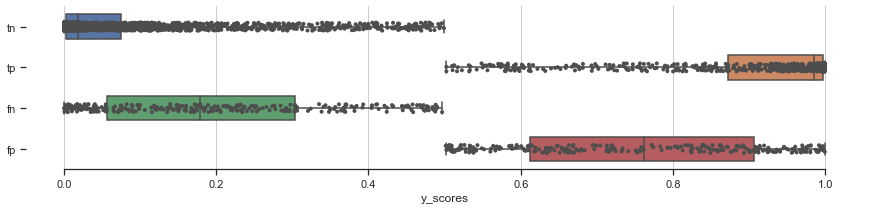

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(15, 3))


# Plot the orbital period with horizontal boxes
sns.boxplot(x="y_scores", y="type", data=df,
            whis=[0, 100], width=.6)

# Add in points to show each observation
sns.stripplot(x="y_scores", y="type", data=df,
            size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

Oben sieht man die Verteilung des Prediction-Score-Werte für tn,tp,fn,fp. Außerdem sieht man die Quartile (die beiden mittleren bilden die Box).

Die beiden folgenden Grafiken schauen sich die fälschlich als "not sexist" gelabelten Daten an und wie sich diese auf die 4 Klassen aus Task B verteilen. Dies wird verglichen, mit der Verteilung für die zuercht als "sexist" gelabelten Daten.

<AxesSubplot:xlabel='label_category', ylabel='count'>

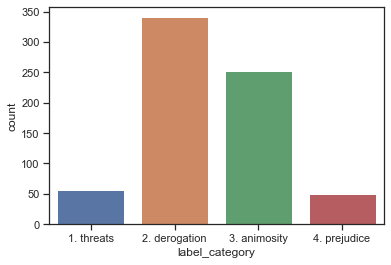

In [ ]:
# barplot of distribution of tp["label_category"]
sns.countplot(x="label_category", data=tp, order = ["1. threats", "2. derogation", "3. animosity", "4. prejudice"])

<AxesSubplot:xlabel='label_category', ylabel='count'>

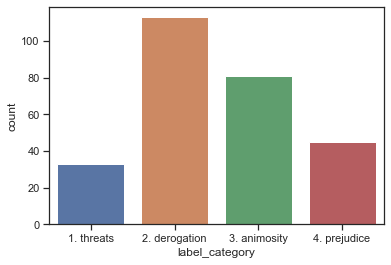

In [ ]:
# barplot of distribution of fn["label_category"] 
sns.countplot(x="label_category", data=fn, order = ["1. threats", "2. derogation", "3. animosity", "4. prejudice"])



c:\Anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


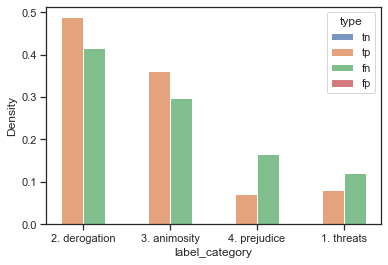

In [ ]:
# concatenate fn and tp
fntp = pd.concat([fn, tp])
ax = sns.histplot(x = fntp['label_category'], hue=df['type'], stat = "density", multiple = "dodge", common_norm = False)
                     
 #               order = ["1. threats", "2. derogation", "3. animosity", "4. prejudice"])

c:\Anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


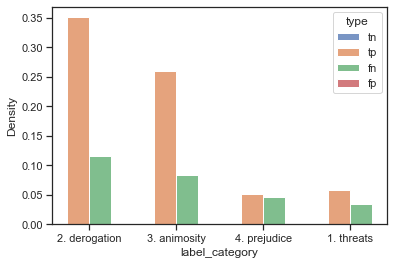

In [ ]:
# concatenate fn and tp
fntp = pd.concat([fn, tp])
ax = sns.histplot(x = fntp['label_category'], hue=df['type'], stat = "density", multiple = "dodge")


Man erkennt klar, dass aus der Klasse "4. prejudice" und "1. threats" anteilig besonders viele positive fälschlich nicht erkannt werden. Die beiden Klassen sind zwar die kleinsten, es wird aber nur jeweweils knapp die Hälfte erkannt. 

Hier noch eine Spielerei mit den feineren Klassen aus Task C, das würde ich aber ignorieren.

c:\Anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


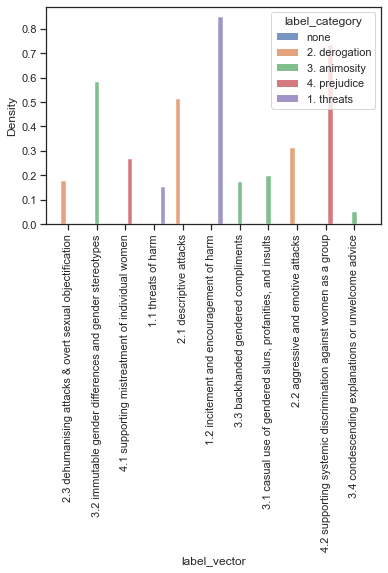

In [ ]:
plt.xticks(rotation=90)
ax = sns.histplot(x = fn['label_vector'], hue=df['label_category'], multiple="dodge", 
                  stat = 'density', shrink = 0.8, common_norm=False)

c:\Anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


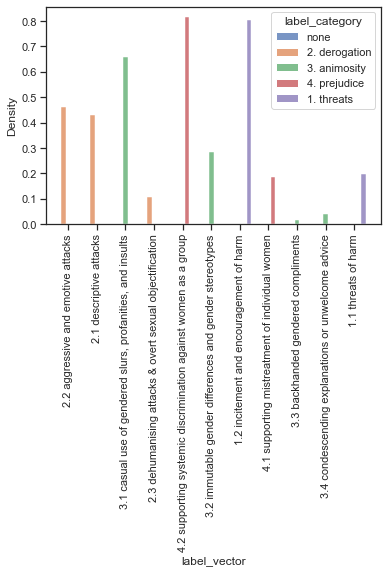

In [ ]:
plt.xticks(rotation=90)
ax = sns.histplot(x = tp['label_vector'], hue=df['label_category'], multiple="dodge", 
                  stat = 'density', shrink = 0.8, common_norm=False)

In [ ]:
all_data.set_format(type="pandas")
alldf = all_data["train"][:]
all_data.reset_format

<bound method DatasetDict.reset_format of DatasetDict({
    train: Dataset({
        features: ['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector', 'split'],
        num_rows: 20000
    })
})>

In [ ]:
alldf.head()

,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape ...",not sexist,none,none,dev
1,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,none,none,train
2,sexism2022_english-13149,This is like the Metallica video where the poo...,not sexist,none,none,train
3,sexism2022_english-13021,woman?,not sexist,none,none,train
4,sexism2022_english-966,I bet she wished she had a gun,not sexist,none,none,dev


In [ ]:
dev = alldf[alldf["split"] == "dev"]
train = alldf[alldf["split"] == "train"]
test = alldf[alldf["split"] == "test"]

In [ ]:
dev_val = dev["label_sexist"].value_counts()
train_val = train["label_sexist"].value_counts()
test_val = test["label_sexist"].value_counts()
print("train:",train_val[1]/(train_val[0]+train_val[1]))
print("dev:",dev_val[1]/(dev_val[0]+dev_val[1]))
print("test:",test_val[1]/(test_val[0]+test_val[1]))


train: 0.24271428571428572
dev: 0.243
test: 0.2425
